In [7]:
#imports
import numpy as np
import pandas as pd
import random
import string

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os
import csv
import datetime
from datetime import timedelta,datetime, date

from scipy import stats

import sklearn
from sklearn import metrics

from sklearn.linear_model import LogisticRegression

In [8]:
cu = pd.read_parquet("customers.parquet")
tr = pd.read_parquet("transactions_2_cleaned.parquet")

In [9]:
exptypes = tr.EXP_TYPE.cat.categories.to_list()
prodtypes = cu.PROD_TYPE.cat.categories.to_list()

cutoprod = {c:v.PROD_TYPE for (c,v) in cu.groupby("CUST_ID")}

In [10]:
grp = tr.loc[:, ["CUST_ID", "EXP_TYPE", "AMOUNT"]].groupby("CUST_ID")
l = []
lcu = []

for (k,v) in grp:
  df2 = v.groupby("EXP_TYPE").apply(lambda x: pd.Series([x.shape[0], 
    x.AMOUNT.sum()], index= ["n", "AMOUNT"]))
  df2.loc[:, "AMOUNT_prop"] = df2.AMOUNT / df2.AMOUNT.sum()
  df2.loc[:, "n_prop"] = df2.n / df2.n.sum()
  df2.loc[:, "AMOUNT_per_n"] = [0.0 if np.isnan(x) else x  
                                for x in df2.AMOUNT / df2.n]
  l.append(df2)
  lcu.append(k)

In [11]:
nc = len(exptypes)
datax = np.zeros((len(l), 3*len(exptypes)))
for (i,v) in enumerate(l):
  datax[i, range(nc)] = v.AMOUNT_prop
  datax[i, range(nc, nc + nc)] = v.n_prop
  datax[i, range(2*nc, 2*nc + nc)] = v.AMOUNT_per_n

datay = [ np.array([float((p == cutoprod[cu]).any())  for cu in lcu]) 
         for p in prodtypes]

In [12]:
def calc_threshold_stats(pr, gt):
  fpr = [];   tpr = [];   thr = np.linspace(0., 1., 101);   prec = [];  recall = []
  for t in thr:
    prl = pr >= t
    fpr.append(np.logical_not(gt[prl]).sum() / np.logical_not(gt).sum())
    tpr.append(gt[prl].sum() / gt.sum())
    recall.append(gt[prl].sum() / gt.sum())
    prec.append(gt[prl].sum() / prl.sum()  if prl.sum() > 0 else 0.)
  return((fpr, tpr, thr, recall, prec))
  
def gen_crossval_indecies(df, kfold):
  n = df.shape[0]
  return(np.random.permutation([int(x // (n/5))  for x in range(n)]))

def rescale_cols(df, scales = None):
  if scales is None:
    scales = (np.apply_along_axis(np.mean, 0, df), 
              np.apply_along_axis(np.std, 0, df))
  
  df2 = df.copy()
  for i in range(len(scales[0])):
    df2[:,i] = 0. if scales[1][i] < 0.000001 else \
      (df2[:,i] - scales[0][i]) / scales[1][i]
  
  return(df2, scales)

def logregr_train(datax, datay):
  model = LogisticRegression(max_iter = 10**5)
  
  model.fit(datax, datay)
  return(model)

In [13]:
def logregr_train_and_eval(datax, datay, trainii, testii):
  model = logregr_train(datax[trainii, :], datay[trainii])
  
  pr = model.predict(datax[testii, :]) == 1.
  gt = datay[testii] == 1.
  
  acc = (pr == gt).mean()
  prec = (pr == gt)[pr].sum() / pr.sum()
  recall = (pr == gt)[gt].sum() / gt.sum()
  f1 = 2*prec*recall / (prec + recall)
  
  (fpr, tpr, thresholds, trecall, tprec) = calc_threshold_stats(
    [x[1]   for x in model.predict_proba(datax[testii, :])], gt)
  
  rocauc= sklearn.metrics.auc(fpr, tpr)
  
  return( {"acc": acc, "prec": prec, "recall": recall, "f1": f1, 
           "fpr": fpr, "tpr": tpr, "thresholds": thresholds, "trecall": trecall,
           "tprec": tprec, "model": model, "rocauc": rocauc} )

def logregr_train_and_eval_cv(datax, datay, kfold):
  cvii = gen_crossval_indecies(datax, kfold)
  ra = {"acc": [], "prec": [], "recall": [], "f1": [], 
        "fpr": [], "tpr": [], "thresholds": [], "trecall": [],
        "tprec": [], "model": [], "rocauc": []}
  for cvi in range(kfold):
    r = logregr_train_and_eval(datax, datay, cvii != cvi, cvii == cvi)
    for x in ra:
      ra[x].append(r[x])
  
  return(ra)

In [14]:
r = [logregr_train_and_eval_cv(datax, datay[i], 5)  
     for i in range(len(prodtypes))]

In [15]:
lst = []
for i in range(len(prodtypes)):
  d = {"prodtype": prodtypes[i]}
  for x in ["acc", "prec", "recall", "f1", "rocauc"]:
    d[x] = np.mean(r[i][x])
    d[x + "_std"] = np.std(r[i][x])

  for j in range(5):
    for x in ["acc", "prec", "recall", "f1", "rocauc"]:
      d["{}{}".format(x, j)] = r[i][x][j]
  lst.append(d)
  
dfres1 = pd.DataFrame(lst)
dfres1.to_excel("outputs/7_logregr_accs.xlsx", index= False)
dfres1

,prodtype,acc,acc_std,prec,prec_std,recall,recall_std,f1,f1_std,rocauc,...,acc3,prec3,recall3,f13,rocauc3,acc4,prec4,recall4,f14,rocauc4
0,Автокредитование,0.868836,0.008298,0.709594,0.053144,0.195977,0.020571,0.306226,0.025462,0.843408,...,0.862227,0.750000,0.167213,0.273458,0.828927,0.874428,0.670213,0.225806,0.337802,0.851617
1,Вклады,0.810371,0.007737,0.824903,0.030906,0.354070,0.015754,0.495201,0.017489,0.877333,...,0.805796,0.784689,0.327345,0.461972,0.865218,0.803254,0.868182,0.347905,0.496749,0.877709
2,Инвестиции,0.947738,0.003317,0.904752,0.017417,0.650079,0.039941,0.755419,0.021996,0.959219,...,0.951195,0.873737,0.709016,0.782805,0.961909,0.943569,0.915584,0.589958,0.717557,0.955239
3,Кредиты,0.859583,0.004518,0.833329,0.026579,0.357596,0.007688,0.500365,0.010818,0.889129,...,0.863244,0.823171,0.360000,0.500928,0.893899,0.851551,0.872093,0.357143,0.506757,0.872200
4,"Лайфстайл (бронирование столиков, покупка биле...",0.914591,0.003938,0.792449,0.045857,0.279796,0.020546,0.413125,0.025643,0.878859,...,0.912049,0.779221,0.277778,0.409556,0.866411,0.914591,0.833333,0.312500,0.454545,0.869747
5,Накопительные счета,0.782308,0.004331,0.676456,0.046781,0.177703,0.005547,0.281210,0.008445,0.807184,...,0.773767,0.728814,0.172345,0.278768,0.805521,0.785460,0.709402,0.176221,0.282313,0.803985
6,Прайват обслуживание,0.951906,0.004345,0.360513,0.097079,0.031290,0.021784,0.055792,0.036705,0.754183,...,0.949670,0.333333,0.020619,0.038835,0.719690,0.958312,0.384615,0.063291,0.108696,0.788538
7,Премиальное обслуживание,0.943976,0.006701,0.515739,0.218418,0.082090,0.035166,0.139637,0.058787,0.799454,...,0.944586,0.250000,0.019048,0.035398,0.823850,0.950178,0.846154,0.102804,0.183333,0.829256
8,Страхование,0.926385,0.003672,0.804659,0.049093,0.301799,0.016394,0.438716,0.022416,0.873589,...,0.923233,0.852941,0.291457,0.434457,0.884205,0.933401,0.869565,0.329670,0.478088,0.883923
9,Услуги для бизнеса,0.938180,0.005864,0.763719,0.024859,0.288283,0.029177,0.417842,0.032433,0.873851,...,0.935435,0.750000,0.301887,0.430493,0.864876,0.945602,0.783333,0.333333,0.467662,0.867196


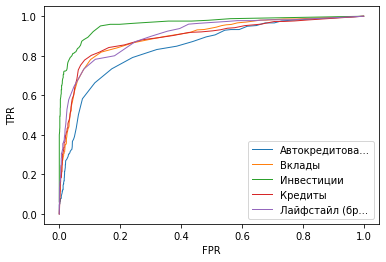

In [16]:
stripstr = lambda x: x if len(x) < 15 else x[0:13] + "..."

for i in range(0,5):
  plt.plot(r[i]["fpr"][0], r[i]["tpr"][0], label= stripstr(dfres1.prodtype[i]), 
           lw=1)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.savefig("outputs/8_logregr_aucs-1.png", dpi= 600, transparent= False, 
  facecolor= "white", backend= "cairo", bbox_inches= "tight")

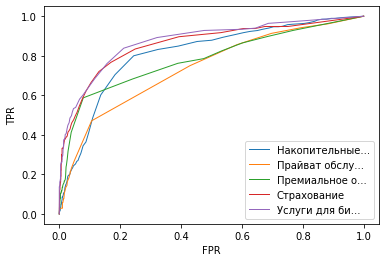

In [17]:
for i in range(5,10):
  plt.plot(r[i]["fpr"][0], r[i]["tpr"][0], label= stripstr(dfres1.prodtype[i]), 
           lw=1)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.savefig("outputs/8_logregr_aucs-2.png", dpi= 600, transparent= False, 
  facecolor= "white", backend= "cairo", bbox_inches= "tight")

In [18]:
modelsfinals = [logregr_train(datax, datay[i])   for i in range(len(prodtypes))]

In [19]:
import pickle
pickle.dump(modelsfinals, open("logregr_models.pickle", 'wb'))

In [21]:
thresh = r[0]["thresholds"][0]
prec = []
recall = []

for i in range(len(r)):
  prec.append(np.mean(np.array(r[i]["tprec"]), axis= 0))
  recall.append(np.mean(np.array(r[i]["trecall"]), axis= 0))

pickle.dump((thresh, prec, recall), open("logregr_thr.pickle", "wb"))